# Kaggle Challenge: Predict Country of Airbnb User's First Booking

### W207 - Spring 2017
### Melanie Costello, Cendy Lin, Giles Ochs, Divya Sriram

**Objective:** In 2016, Airbnb sponsored a Kaggle competition in which it provided two datasets - one with information about its users (users data) and the other with information about their activities on Airbnb.com (sessions data).  The objective was to predict the country in which an Airbnb guest would make their first booking.  

From the competition site: "There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking."

Complete details about the competition can be found here: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data.

## Part 1: Basic Data Prep

Airbnb provided a training set and test, but we wanted to also have a set of development data.  We elected to slplit off part of the training data to create a dev set.  The original training data contained approximately 213,000 rows. We decided to split the development so that it would contain 12% the original training set. On the full data set, this turns out to be 25,000 rows on the development data and approximately 188,000 rows on the training data. 

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pylab as pl

# Set seaborn style
sns.set_context("notebook", font_scale=1.5)

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn import preprocessing

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# Matplotlib libraries for visualization
from matplotlib.colors import LogNorm
from statsmodels.graphics.mosaicplot import mosaic
from pylab import rcParams

/Users/divyas/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/divyas/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
# Read in original train set
d = pd.read_csv('../zip_files/train_users_2.csv.zip')

# Read in training and dev data sets
train = pd.read_csv('../train_dev_data/train_data.csv')
dev = pd.read_csv('../train_dev_data/dev_data.csv')

# Split off training labels & dev labels
train_labels = train.country_destination
dev_labels = dev.country_destination

# Make the dataset tiny for testing purposes
# train = train[:15000]
# train_labels = train_labels[:15000]

We first focused on exploring the user data, which contains attributes of individuals who first used Airbnb between 2010 and mid-2014.  In examining the fields available, we quickly realized much of the data is categorical.  We knew this would be a bit of a challenge, since the sklearn models take numeric values as inputs.  We needed to understand how to appropriately convert these categorical variables to numeric values in order to develop our baseline model. 

In [60]:
# Examine data in avaialble fields
train.head()

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,number_devices,longest_session,total_time_on_site,action_detail,first_hour,month_created,season_created,year_created,bin_age,bin_lang
7000,b4amt3o7t1,2014-01-22,20140122013130,MALE,32.0,basic,0,en,direct,direct,...,1.0,132051.0,488130.0,change_contact_host_dates,1,01,Winter,2014,30-45,en
7001,zyz889qlnv,2014-01-22,20140122013639,MALE,28.0,facebook,0,en,sem-brand,google,...,1.0,88649.0,304046.0,view_search_results,1,01,Winter,2014,Under30,en
7002,y975i3z4uz,2014-01-22,20140122014148,FEMALE,30.0,basic,0,en,sem-brand,google,...,1.0,364432.0,710668.0,confirm_email_link,1,01,Winter,2014,30-45,en
7003,143wftj6nx,2014-01-22,20140122014507,-unknown-,NaN,basic,0,en,direct,direct,...,1.0,277635.0,1271871.0,view_search_results,1,01,Winter,2014,Unknown,en
7004,0ar0xi9ujt,2014-01-22,20140122014618,FEMALE,27.0,basic,0,en,direct,direct,...,1.0,184047.0,772708.0,view_search_results,1,01,Winter,2014,Under30,en


## Part 2: Baseline Model Submission

The Airbnb Kaggle challenge is ultimately a classification problem.  We need to predict in which class a user's first booking falls.  It is important to note that, per the competition rules, 'NDF' (no destination found) is a valid value to predict, as is 'other' (indicating a booking happened, but in a country not listed in the rest of labels).  

We tried a handful of classification algorithms, including Bernoulli Naive Bayes and Logistic Regression, but ultimately settled on using a K Nearest Neighbors model for our baseline subission. To support the use of categorical data in the model, we used the pandas function get_dummies() to binarize the categorical variables used in the model.

In [7]:
# Transform variables we want to use into binary
test_cols = ['language', 'gender']
tr_binary_vars = pd.get_dummies(train[test_cols], columns=test_cols)
dev_binary_vars = pd.get_dummies(dev[test_cols], columns=test_cols)

# Note that the unique values in the language & gender columns are now their own
# columns with values of 1 or 0
dev_binary_vars.head()

,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hu,language_id,...,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
# Note that training data do not have all the same languages in them
# We will add columns to make the training data match dev

# List of columns in transformed training data & dev data
tr_list = list(tr_binary_vars.columns.values)
dev_list = list(dev_binary_vars.columns.values)

# difference between the sets - training data has 2 extra columns, language_ca & language_hr
np.setdiff1d(tr_list, dev_list)

# Add columns to training data
dev_binary_vars.insert(0, 'language_ca', 0, allow_duplicates=False)
dev_binary_vars.insert(9, 'language_hr', 0, allow_duplicates=False)

In [9]:
# Create arrays based on the variables we want to use
train_array = np.array(tr_binary_vars)
train_label_array = np.array(train_labels)

dev_array = np.array(dev_binary_vars)
dev_label_array = np.array(dev_labels)

In [10]:
# Try a KNN model - iterating through a handful of different values of k
def mod_test(k_vals, train_data, train_labels, dev_data, dev_labels=None):

    # We want to evaluate a variety of values for k, so we need
    # to enclose our work in a loop.
    for elem in k_vals:
        
        # Create a classifier object, fit our training data &
        # initialize a variable to hold the predictions
        knn = KNeighborsClassifier(n_neighbors=elem)
        knn.fit(train_data, train_labels)
        preds = knn.predict(dev_data)
        
        # We evaluate the accuracy for each value of k by comparing
        # the predictions and the labels, then updating values for
        # correct and total
        correct, total = 0, 0
        for pred, label in zip(preds, dev_labels):
            if pred == label: 
                correct += 1
            total += 1
        print 'For k=%s, total: %3d  correct: %3d  accuracy: %3.3f' %(elem, total, correct, 1.0*correct/total)

k_vals = [7, 10, 15, 20, 50]
mod_test(k_vals, train_array[:5000], train_label_array[:5000], dev_array[:2000], dev_label_array[:2000])

For k=7, total: 2000  correct: 772  accuracy: 0.386
For k=10, total: 2000  correct: 1158  accuracy: 0.579
For k=15, total: 2000  correct: 1159  accuracy: 0.580
For k=20, total: 2000  correct: 1159  accuracy: 0.580
For k=50, total: 2000  correct: 1159  accuracy: 0.580


We then ran the same model on our test data, electing to use k=15 since that achieved the highest accuracy with the smallest k.

In [11]:
# Use KNN to predict on test data
# Get test data
test = pd.read_csv('../unzipped_files/test_users.csv')

# Process test data so it matches layout of training data
test_cols = ['language', 'gender']
test_binary_vars = pd.get_dummies(test[['language', 'gender']], columns=test_cols)

# List of columns in transformed training data & dev data
tr_list = list(tr_binary_vars.columns.values)
test_list = list(test_binary_vars.columns.values)

# Examine difference between the sets
# Train list has language_hr and language_is
# Test list has language_-unknown-
np.setdiff1d(test_list, tr_list)

# Drop columns that don't exist in both
tr_binary_vars = tr_binary_vars.drop(["language_is", "language_hr"], axis=1)
test_binary_vars = test_binary_vars.drop(["language_-unknown-"], axis=1)

# Create arrays based on the variables we want to use
train_array = np.array(tr_binary_vars)
train_label_array = np.array(train_labels)
test_array = np.array(test_binary_vars)

In [12]:
# Predict outcomes on test data using k=15
def mod_score(k_val, train_data, train_labels, test_data):
        
    # Create a classifier object, fit our training data &
    # initialize a variable to hold the predictions
    knn = KNeighborsClassifier(n_neighbors=k_val)
    knn.fit(train_data, train_labels)
    preds = knn.predict(test_data)
        
    return preds

test_preds = mod_score(15, train_array[:5000], train_label_array[:5000], test_array)

# Examine unique values of the predictions, noting that we are predicting
# the same value for all entries
np.unique(test_preds)

array(['NDF'], dtype=object)

**NOTE:** On our test data, we discovered that the model is predicting the same value for every entry - a lable of 'NDF' (no destination found).  In doing so, we still achieved an accuracy of 0.69 on our submission to Kaggle.  This tells us that a large portion of the test cases indeed map to a value of 'NDF' - meaning we need to devote our next steps to understanding which values will be most predictive for labels other than 'NDF'.  

Additionally, we know that high dimensionality can hamper the effectiveness of KNN.  With so many unique values for our categorical variables (such as language), binarizing all of them will not suffice.  We need to think of ways to reduce the dimensionality of our data, perhaps with binning.

## Part 3: Additional Data Exploration

Based on what we learned from our baseline submission, we decided to visualize some of our variable distributions and develop some hypotheses for the types of feature engineering we want to incorporate (binning variables, parsing information, aggregating, etc.).  

### Target Variable: Country Destination (classes)

% NDF: 58.3133016009
% US: 29.2404922234
% Non-US: 12.4462061756


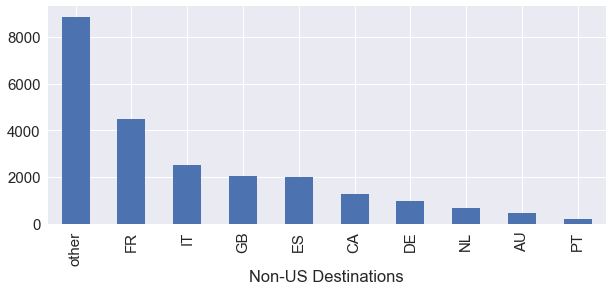

In [13]:
# Exploring labels
total = sum(train_labels.value_counts())
train_labels.value_counts()/total

print "% NDF:", (1.0 * train_labels.value_counts()[0]/total * 100)
print "% US:", (1.0 * train_labels.value_counts()[1]/total * 100)
print "% Non-US:", (1.0 * sum(train_labels.value_counts()[2:])/total * 100)

# Looking at Non-U.S. bookings - removing NDF examples too
plt.figure(figsize=(10,4))
nonUS = train_labels[train_labels != 'NDF'][train_labels!= 'US']
nonUS.value_counts(dropna=False).plot(kind='bar')
plt.xlabel('Non-US Destinations')

We see that users predominantly have NDF (no destination found) or U.S. bookings, with the two totalling to about 88% of observations. This makes sense as most users have an account but do not book. Users are probably mostly American (though we do not have this data), and book in their country of origin. Non-U.S. bookings total to 12%, with the second most common country identified as France, followed by Italy and Great Britain.

### Gender

Next, we examine gender counts as whether there is a difference in destination countries between the two genders. 

-unknown-    84462
FEMALE       55636
MALE         48095
OTHER          258
Name: gender, dtype: int64


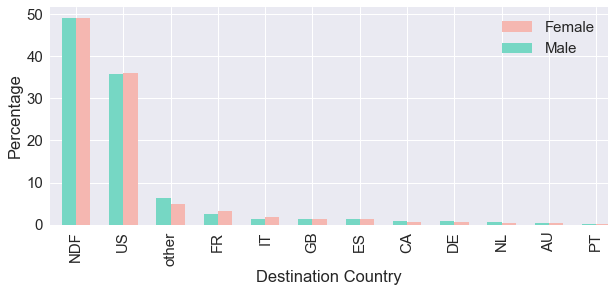

In [14]:
print(train.gender.value_counts())

f = train[train['gender'] == 'FEMALE']
m = train[train['gender'] == 'MALE']
o = train[train['gender'] == 'OTHER']

fem = f.country_destination.value_counts() / len(f) * 100
mal = m.country_destination.value_counts() / len(m) * 100
oth = o.country_destination.value_counts() / len(o) * 100

# Bar width for plot
width = 0.3

plt.figure(figsize=(10,4))
fem.plot(kind='bar', width=width, color='#F5B7B1', position=0, label='Female')
mal.plot(kind='bar', width=width, color='#76D7C4', position=1, label='Male')

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

Generally speaking it looks like men and women have similar booking behaviors, thoughh women may be slightly more likely to book in France and Italy that in other countries (outside of NDF and US). 

### Age

CENDY - DO YOU MIND CHECKING THIS... I WAS GUESSING WHICH DATASET YOU WERE USING FOR 'd' AND GUESSED TRAIN... BUT IT THE RESULTS FOR THE COLORFUL BARGRAPH DON'T LINE UP WITH WHAT YOU WROTE NOW.

count    110875.000000
mean         49.334025
std         153.585847
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64
('NaN age:', 77576)
('Age over 120:', 672)

Age over 100 detail:
371     2014.0
387     2014.0
621     2014.0
1099    2014.0
1857    2013.0
Name: age, dtype: float64


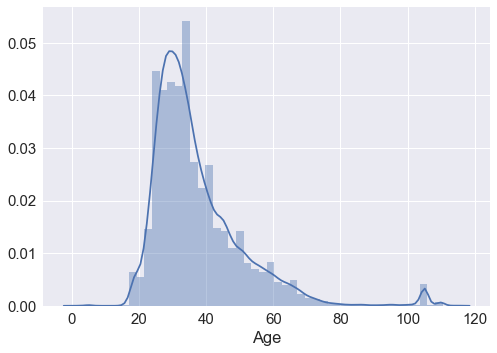

In [15]:
print(train.age.describe())
print("NaN age:", sum(train.age.isnull()))
print("Age over 120:", sum(train.age > 120))
print("\nAge over 100 detail:")
print(train.age[train['age'] > 120].head(5)) 

sns.distplot(train.age.dropna()[train.age < 120])
plt.xlabel('Age')
sns.despine()

It looks like we have a positively skewed aged distribution, with the median age being 34 years old. We have a suspicious bump right after 100 years of age that might be an error. We also have individuals who have typed in what looks like a year instead of their age (e.g. '2014').  

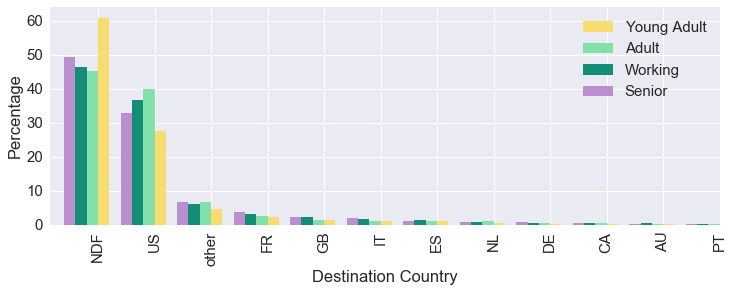

       adult  senior  working  young
AU        31       1       26     14
CA       138       4       48     63
DE        70       5       33     29
ES       148       9       68    108
FR       340      30      166    229
GB       150      17      119    103
IT       202      16       96    142
NDF     6373     391     2543   6414
NL        58       7       27     28
PT        14       1        9     15
US      5657     259     2017   2900
other    950      52      338    480


In [38]:
age0 = 30
age1 = 45
age2 = 65
age3 = 100

young = train.loc[d['age'] < age0, 'country_destination'].value_counts()
adult = train.query('age > @age0 & age < @age1').country_destination.value_counts()
working = train.query('age > @age1 & age < @age2').country_destination.value_counts()
senior = train.query('age > @age2 & age < @age3').country_destination.value_counts()

young_dest = young / sum(young) * 100
adult_dest = adult / sum(adult) * 100
working_dest = working / sum(working) * 100
senior_dest = senior / sum(senior) * 100

# Bar width
width = 0.2

plt.figure(figsize=(12,4))
young_dest.plot(kind='bar', width=width, color='#F7DC6F', position=0, label='Young Adult')
adult_dest.plot(kind='bar', width=width, color='#82E0AA', position=1, label='Adult')
working_dest.plot(kind='bar', width=width, color='#138D75', position=2, label='Working')
senior_dest.plot(kind='bar', width=width, color='#BB8FCE', position=3, label='Senior')

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

print(pd.DataFrame(dict(young = young, adult = adult, working = working, senior = senior)).to_string())

When examining age bins, it looks like senior (ages 65+) are more likely to have no booking than other generations. Other age groups still have higher NDF reults, but are more likely than seniors to book in the U.S. or other countries.

### Pie Chart

In [69]:
country_counts = train['country_destination'].value_counts()

In [70]:
country_counts

NDF      40770
US       18113
other     3311
FR        1298
IT         898
GB         679
ES         651
CA         421
NL         232
DE         229
AU         135
PT          78
Name: country_destination, dtype: int64

In [66]:
print "%s" %country_counts[1]

18113


In [80]:
NDF = country_counts[0]
US = country_counts[1]
NONUS = sum(country_counts[2:])

In [92]:
print "NDF %d" %NDF
print "US %d" %US
print "NONUS %d" %NONUS

NDF 40770
US 18113
NONUS 7932


In [95]:
countries =  pd.DataFrame({ 'COUNTRY' : ['NDF', 'US', 'NON US'] , 'COUNT' : [40770,18113,7932] })

In [96]:
countries

,COUNT,COUNTRY
0,40770,NDF
1,18113,US
2,7932,NON US


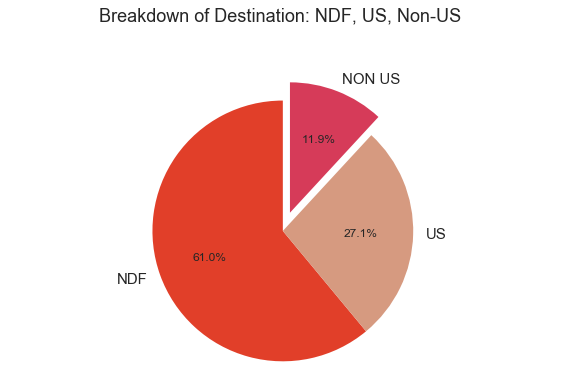

In [101]:
# Create a list of colors (from iWantHue)
colors = ["#E13F29", "#D69A80", "#D63B59"]

# Create a pie chart
plt.pie(
    # using data total)arrests
    countries['COUNT'],
    # with the labels being officer names
    labels=countries['COUNTRY'],
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with one slide exploded out
    explode=(0, 0, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    )

# View the plot drop above
plt.axis('equal')
plt.title('Breakdown of Destination: NDF, US, Non-US \n \n')

# View the plot
plt.tight_layout()
plt.show()

### First Browser

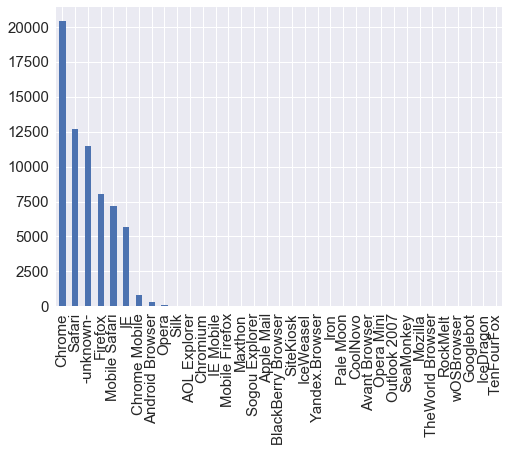

In [39]:
train.first_browser.value_counts().plot(kind='bar')
# rcParams['figure.figsize'] = 10, 100

Though there are around 50+ options for the first browser used, just the top 10 browsers account for majority of the data points, with the bottom half of the list of browsers used just once. First browser might be indicative of destination booked, let's explore further.

### Month + Country of Destination

Can we see an obvious influence on the choice of destination based on what month the booking was made?

In [40]:
train['date'] = pd.to_datetime(train['date_account_created'])
train['month_account_created'] = train['date'].apply(lambda x: x.strftime('%B')) 

In [16]:
train.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date,month_account_created
0,g936neasyy,2013-05-12,20130512210934,2013-05-13,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome,other,2013-05-12,May
1,duq2vabpp2,2013-03-02,20130302054534,NaN,FEMALE,31.0,facebook,0,en,direct,direct,untracked,Web,iPad,Mobile Safari,NDF,2013-03-02,March


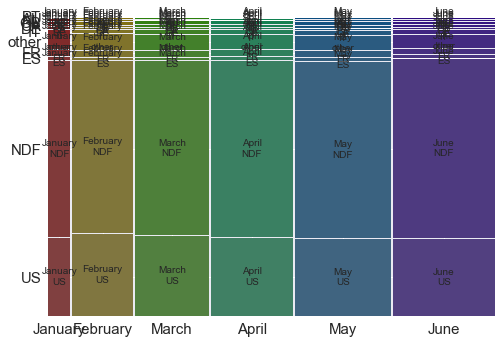

In [41]:
plt.rcParams['font.size'] = 12.0
mosaic(train, ['month_account_created', 'country_destination']);
# rcParams['figure.figsize'] = 10, 100

From this visualization, there is no drastic influence that the variable 'month' has choice of destination, however the small differences could still be of value to use in our prediction models. The distribution of NDF and US bookings validates that NDF/US are the most popular outcomes, spread (relatively) evenly across months.

## Part 4: Feature Engineering

Once we had some hypotheses about which variables would be predictive, we set out to pre-process our data to better support our modeling work.  We decided to do the following: ##CENDY, DIVYA, GILES - CAN YOU ADD TO THE LIST THE FEATURE ENGINEERING PIECES YOU DID?##
+ Parse the month from the account creation date
+ Create a variable to represent the season the account was created
+ Parse the year from the account creation date
+ Bin ages
+ Bin languages


See the "Sessions" Workbook for the following:
+ New parameter: Total number of visists by user
+ New Parameter: Total number of different device type used by user to access Airbnb
+ New Paramter: The longest amount of time user spent on a single action in Airbnb
+ New Parameter: The aggregate amount of time user spent on Airbnb
+ New Parameter: The last action the user performend on Airbnb
+ New Parameter: The delta between when a user created their account, and when they made their first booking
+ New Parameter: The hour of day that the user accessed Airbnb for the very first time



In [42]:
# Function to parse month from date columns
def parse_month(col):
    start = str(col).find("-")
    if start != -1:
        end = col.find("-", start+1)
        month = col[start+1:end]
        return month
    else:
        return '00'

train["month_created"] = train.date_account_created.apply(parse_month)
dev["month_created"] = dev.date_account_created.apply(parse_month)
test["month_created"] = test.date_account_created.apply(parse_month)


# Function to convert months to seasons
def parse_season(col):
    if col in ('12', '01', '02'):
        return 'Winter'
    elif col in ('03', '04', '05'):
        return 'Spring'
    elif col in ('06', '07', '08'):
        return 'Summer'
    else:
        return 'Fall'
    
train["season_created"] = train.month_created.apply(parse_season)
dev["season_created"] = dev.month_created.apply(parse_season)
test["season_created"] = test.month_created.apply(parse_season)

# Function to parse year from date columns
def parse_year(col):
    stop = str(col).find("-")
    if stop != -1:
        year = col[:stop]
        return year
    else:
        return '0000'

train["year_created"] = train.date_account_created.apply(parse_year)
dev["year_created"] = dev.date_account_created.apply(parse_year)
test["year_created"] = test.date_account_created.apply(parse_year)

# Function to bin ages
def bin_age(col):
    if col >= 65 and col < 100:
        return "65-100"
    elif col >=45 and col < 65:
        return "45-65"
    elif col >=30 and col < 45:
        return "30-45"
    elif col >= 0 and col < 30:
        return "Under30"
    else:
        return "Unknown"
    
train["bin_age"] = train.age.apply(bin_age)
dev["bin_age"] = train.age.apply(bin_age)
test["bin_age"] = test.age.apply(bin_age)

# Function to bin languages, leaving only those with a frequency >= 100 in the training data.
# All others will be labeled as 'other'
def bin_lang(col):
    if col in ('en', 'zh', 'es', 'fr'):
        return col
    else:
        return 'other'

train["bin_lang"] = train.language.apply(bin_lang)
dev["bin_lang"] = dev.language.apply(bin_lang)
test["bin_lang"] = test.language.apply(bin_lang)

## Part 5a: Decision Tree Model

Recognizing that we're working with a lot of categorical data, we decided to explore the idea of working with a decision tree.  Decision trees generally work well with categorical data and are also easy to explain.  A visual output can help the model builder understand exactly which features and split points are important.  

Because the sklearn DecisionTree function needs numeric data as an input, we used the function LabelEncoder() to transform the data. This is different than the binarization of the data we did for the KNN baseline model.  LabelEncoder simply assigns a numeric representation of a categorical value.  So for gender, MALE may be 0, FEMALE 1 and UNKNOWN 2 and so on. 

We then tried a variety of variables as inputs, assessing both accuracy & the importance of each feature to the model.  We also wanted to determine if the model was predicting more values than just 'NDF' as the baseline did.

In [19]:
# Define a function that will encode columns for decision tree
def label_encode(df, cols):
    le = preprocessing.LabelEncoder()
    for elem in cols:
        df[[elem]] = le.fit_transform(df[[elem]]) 
    return df

# initial crack at variable selection
cols = ['age', 'season_created', 'month_created', 'bin_age', 'year_created', 
        'bin_lang', 'gender']

dt_train = train[cols]
label_encode(dt_train, cols)

dt_dev = dev[cols]
label_encode(dt_dev, cols)

# Preprocess train & dev labels for decision tree
le = preprocessing.LabelEncoder()
dt_train_labels = le.fit_transform(train_labels)
dt_dev_labels = le.fit_transform(dev_labels)

/Users/divyas/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/divyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/divyas/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


PREDICTING ON DEV DATA:
Best score is 0.660 with sample size of 1000


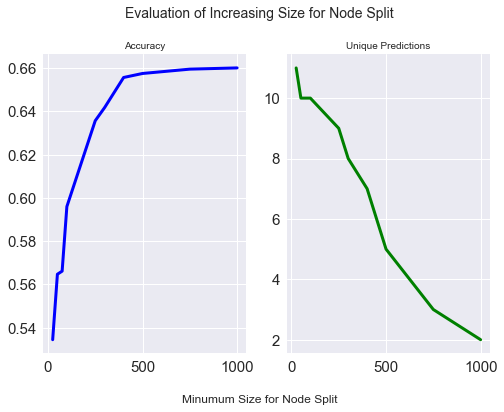

In [54]:
def decision_tree(dt_train, dt_train_labels, dt_dev, dt_dev_labels, best_sample):
    sample_sizes = [25, 50, 75, 100, 250, 300, 400, 500, 750, 1000]
    scores = []
    max_score = [0, 0]
    important_feat = []
    num_unique = []
    for elem in sample_sizes:

        # Fit decision tree model
        dt = DecisionTreeClassifier(criterion="gini", min_samples_split=elem, random_state=99)
        dt.fit(dt_train, dt_train_labels)

        # Predict with decision tree
        preds = dt.predict(dt_dev)
        if elem == best_sample:
            pred_values_nodesplit500 = preds
            dt_dev_labels_nodeplit500 = dt_dev_labels

        # Catalog the unique values & scores predicted for each sample size
        unique = pd.Series(preds).unique()
        num_unique.append(len(unique))
        score = dt.score(dt_dev, dt_dev_labels)
        scores.append(score)

        # Track the max score & what sample size was used, as well as
        # the feature importances for the best score
        if score > max_score[1]:
            max_score = [elem, score]
            important_feat = dt.feature_importances_ 

    # Output best score
    print "PREDICTING ON DEV DATA:"
    print "Best score is %.3f with sample size of %d" % (max_score[1], max_score[0])
    return sample_sizes, scores, num_unique, important_feat, dt_dev_labels_nodeplit500, pred_values_nodesplit500

# Call function
sample_sizes, scores, num_unique, important_feat, dt_dev_labels_nodeplit500, pred_values_nodesplit500 = decision_tree(dt_train, dt_train_labels, dt_dev, dt_dev_labels, 750)


# Create plot to show relationship between minimum size for split & accuracy
plt.figure(figsize=(2,3))
fig, (ax0, ax1) = plt.subplots(ncols=2)
fig.suptitle("Evaluation of Increasing Size for Node Split", y = 1, fontsize=14)
fig.text(0.5, 0, "Minumum Size for Node Split", ha='center')

ax0.plot(sample_sizes, scores, 'b', label='Accuracy', linewidth=3)
ax0.set_title("Accuracy", fontsize=10)

ax1.plot(sample_sizes, num_unique, 'g', label='Unique Predictions', linewidth=3)
ax1.set_title("Unique Predictions", fontsize=10)

plt.show()


On the dev data, we see the best performance is 60.2% accuracy.  This is a nearly 2% increase over the prediction on the dev set in our baseline model.  We got to this by exploring different thresholds for the minimum size on which the model will split a node.  If we keep the minimum size too small, we run the risk of overfitting.  Our best performance was with a size of 750.  So if each entry represents a person, the node will only be eligible to split again if there are more than 750 "people" in it.  The model's accuracy starts to decline once the node size increases over 750.  

We can also see that the number of unique values predicted decreases as the node size increases.  At a minimum split of 750, we are predicting more than one unique value.  We are predicting roughly 8 unique values.

Next, we want to assess the importance of each feature.

[  5.82645987e-01   5.00278373e-04   3.69730524e-03   0.00000000e+00
   0.00000000e+00   4.44080502e-03   1.20235817e-02   1.80516995e-01
   0.00000000e+00   2.36421087e-02   6.28881634e-03   1.76109494e-02
   9.99820308e-03   3.56874654e-03   3.42219763e-03   2.59952823e-02
   2.94140657e-03   8.96123805e-02   3.30949573e-02]


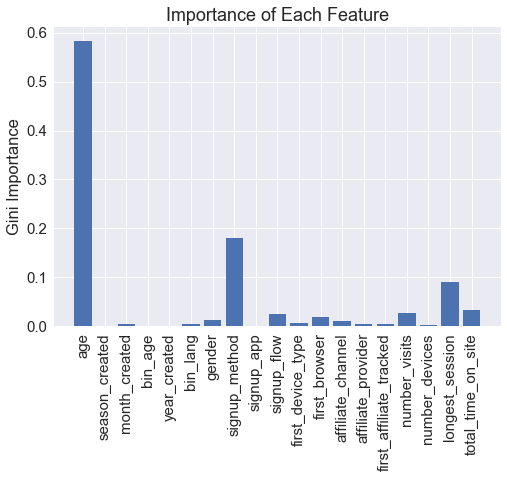

In [44]:
print important_feat
# Create plot to show degree of importance for each feature
num_labels = [c for c in range(len(cols))]
labels = cols
plt.bar(num_labels, important_feat, align='center')
plt.xticks(num_labels, labels, rotation='vertical')
plt.ylabel('Gini Importance')
plt.title("Importance of Each Feature")
plt.show()

Age appears to be the most predictive value, followed by gender.  Our feature-engineered variables of year_created and month_created also seem to be useful.  

Airbnb has also provided sessions data, which contains information about users' behavior when they are on the site.  We want to incorporate variables from this data to see if we can improve the accuracy of our model.  It's important to note that the sessions data represents a narrower, more current time period than the user data does.  Because of that we want to work with the most complete dataset possible.  We chose to combine the datasets into a 'modern' dataset and rework our model.  The code to do this can be found in XXXX notebook.  ##GILES OR CENDY - CAN YOU ADD THIS & COMPLETE THE REFERENCE HERE?##

### Decision tree model with sessions data

In [53]:
# Read in modern dataset containing user & sessions data
# Split into dev & train sets
train = pd.read_csv('../train_dev_data/modern_train.csv', index_col=0)
dev = train[:7000]
train = train[7000:]

# Split off training labels & dev labels
train_labels = train.country_destination
dev_labels = dev.country_destination

# Run feature engineering functions
train["month_created"] = train.date_account_created.apply(parse_month)
dev["month_created"] = dev.date_account_created.apply(parse_month)

train["season_created"] = train.month_created.apply(parse_season)
dev["season_created"] = dev.month_created.apply(parse_season)

train["year_created"] = train.date_account_created.apply(parse_year)
dev["year_created"] = dev.date_account_created.apply(parse_year)

train["bin_age"] = train.age.apply(bin_age)
dev["bin_age"] = train.age.apply(bin_age)

train["bin_lang"] = train.language.apply(bin_lang)
dev["bin_lang"] = dev.language.apply(bin_lang)


We decide to repeat the same process with the added sessions data, using every column, and see if we can improve our accuracy.

In [46]:
# Include every column
cols = ['age', 'season_created', 'month_created', 'bin_age', 'year_created', 
        'bin_lang', 'gender','signup_method', 'signup_app', 'signup_flow', 'first_device_type', 'first_browser',
        'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'number_visits', 'number_devices',
        'longest_session', 'total_time_on_site']

# Label encode our training & dev data for input to decision tree
dt_train = train[cols]
label_encode(dt_train, cols)

dt_dev = dev[cols]
label_encode(dt_dev, cols)

# Preprocess train & dev labels for decision tree
le = preprocessing.LabelEncoder()
dt_train_labels = le.fit_transform(train_labels)
dt_dev_labels = le.fit_transform(dev_labels)

/Users/divyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PREDICTING ON DEV DATA:
Best score is 0.651 with sample size of 750


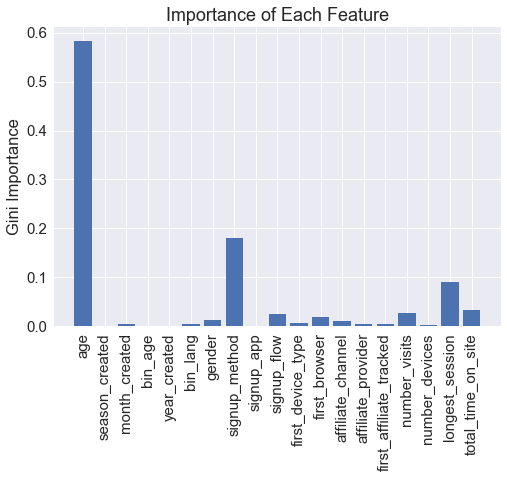

In [47]:
# Call function
sample_sizes, scores, num_unique, important_feat, dt_dev_labels_nodeplit500, pred_values_nodesplit500 = decision_tree(dt_train, dt_train_labels, dt_dev, dt_dev_labels, 750)

# Create plot to show degree of importance for each feature
num_labels = [c for c in range(len(cols))]
labels = cols
plt.bar(num_labels, important_feat, align='center')
plt.xticks(num_labels, labels, rotation='vertical')
plt.ylabel('Gini Importance')
plt.title("Importance of Each Feature")
plt.show()


We see some features are just not useful.  We're going to pare down the list of input variables to improve accuracy and then do some error analysis to see where we're going wrong.

In [48]:
# Use pared down list of columns
cols = ['age', 'month_created', 'gender','signup_method', 'signup_flow', 'first_device_type', 
        'first_browser', 'affiliate_channel', 'number_visits', 'longest_session', 'total_time_on_site']


# Label encode our training & dev data for input to decision tree
dt_train = train[cols]
label_encode(dt_train, cols)

dt_dev = dev[cols]
label_encode(dt_dev, cols)

# Preprocess train & dev labels for decision tree
le = preprocessing.LabelEncoder()
dt_train_labels = le.fit_transform(train_labels)
dt_dev_labels = le.fit_transform(dev_labels)

# Call decision tree function
sample_sizes, scores, num_unique, important_feat, dt_dev_labels_nodeplit500, pred_values_nodesplit500 = decision_tree(dt_train, dt_train_labels, dt_dev, dt_dev_labels, 750)

/Users/divyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PREDICTING ON DEV DATA:
Best score is 0.656 with sample size of 750


By paring down our input variables, we are able to improve the model's accuracy by 0.5%.  However, we are predicting fewer unique features.  Now we want to take a closer look at where the model is making mistakes and see if we can improve its ability to predict more unique features.

### Error Analysis: Confusion Matrix

Building testing confusion matrix...


NameError: global name 'score' is not defined

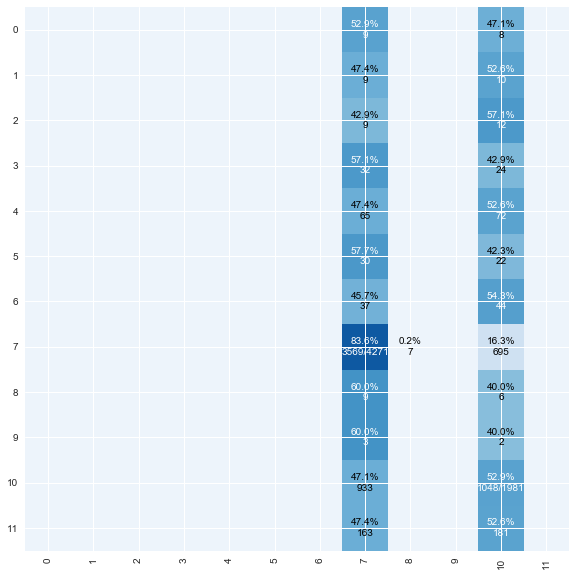

In [55]:
def confusion_mat(dt_dev_labels_nodeplit500, pred_values_nodesplit500):
    # get overall accuracy and F1 score to print at top of plot
    pscore = metrics.accuracy_score(dt_dev_labels_nodeplit500, pred_values_nodesplit500)
    #score = metrics.f1_score(y_test, pred, pos_label=list(set(y_test)))
    # get size of the full label set
    unique_pred_values_nodesplit500 = np.unique(pred_values_nodesplit500)
    unique_dev_labels = np.unique(dt_dev_labels_nodeplit500)
    dur = len(unique_dev_labels)
    print "Building testing confusion matrix..."
    # initialize score matrices
    trueScores = np.zeros(shape=(dur,dur))
    predScores = np.zeros(shape=(dur,dur))
    # populate totals
    for i in xrange(len(dt_dev_labels_nodeplit500)-1):
      trueIdx = dt_dev_labels_nodeplit500[i]
      predIdx = pred_values_nodesplit500[i]
      trueScores[trueIdx,trueIdx] += 1
      predScores[trueIdx,predIdx] += 1
    # create %-based results
    trueSums = np.sum(trueScores,axis=0)
    conf = np.zeros(shape=predScores.shape)
    for i in xrange(len(predScores)):
      for j in xrange(dur):
        conf[i,j] = predScores[i,j] / trueSums[i]
    # plot the confusion matrix
    hq = pl.figure(figsize=(10,10));
    aq = hq.add_subplot(1,1,1)
    aq.set_aspect(1)
    res = aq.imshow(conf,cmap=pl.get_cmap('Blues'),interpolation='nearest',vmin=-0.05,vmax=1.)
    width = len(conf)
    height = len(conf[0])
    done = []
    # label each grid cell with the misclassification rates
    for w in xrange(width):
      for h in xrange(height):
          pval = conf[w][h]
          c = 'k'
          rais = w
          if pval > 0.5: c = 'w'
          if pval > 0.001:
            if w == h:
              aq.annotate("{0:1.1f}%\n{1:1.0f}/{2:1.0f}".format(pval*100.,predScores[w][h],trueSums[w]), xy=(h, w), 
                      horizontalalignment='center',
                      verticalalignment='center',color=c,size=10)
            else:
              aq.annotate("{0:1.1f}%\n{1:1.0f}".format(pval*100.,predScores[w][h]), xy=(h, w), 
                      horizontalalignment='center',
                      verticalalignment='center',color=c,size=10)
    # label the axes
    pl.xticks(range(width), unique_dev_labels[:width],rotation=90,size=10)
    pl.yticks(range(height), unique_dev_labels[:height],size=10)
    # add a title with the F1 score and accuracy
    aq.set_title(" Prediction, Test Set (f1: "+"{0:1.3f}".format(score)+', accuracy: '+'{0:2.1f}%'.format(100*pscore)+", " + str(len(unique_dev_labels)) + " items)",fontname='Arial',size=10,color='k')
    aq.set_ylabel("Actual",fontname='Arial',size=10,color='k')
    aq.set_xlabel("Predicted",fontname='Arial',size=10,color='k')
    pl.grid(b=True,axis='both')
    # save it
    pl.savefig("pred.conf.test.png")
    
confusion_mat(dt_dev_labels_nodeplit500, pred_values_nodesplit500)

We can see that the model is fairly good at accurately predicting a label of 7 (which represents 'NDF' - No Destination Found).  But there are 1056 cases where the model predicts NDF, and the actual label should be US. Additionally, there are 183 cases where it is predicting NDF, and the actual label should be 'other.' 

The model is only marginally good at predicting a label of 10, which represents US.  It accurately predicts this label 46.7% of the time.  However there are 601 cases in chich it predicts a label of US when it should be NDF, and there are 161 cases in which it predicts US when the label should be other.  

We want to see if we can reduce the signal from NDF and boost the signal from other classes to improve prediction.

### Adding Bias: Boosting signal from rare events

In [50]:
# Define function to replicate rows with specific values, in a specific column
# This will allow us to boost the signal associated with underrepresented labels
def repeat_rows(df, vals, boost=2, column='country_destination'):
    new_df = df
    for val in vals:
        for i in range(boost):
            is_value = df[column] == val
            df_try = df[is_value]
            new_df = new_df.append([df_try],ignore_index=True)
    return new_df.sample(frac=1).reset_index(drop=True)

# Add labels column back to training data to make function work
dt_train['country_destination'] = train_labels

vals = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT',
       'other']
bias_train = repeat_rows(dt_train, vals, boost=1)

# Split off training labels & dev labels
train_labels = bias_train.country_destination
# Preprocess train & labels for decision tree
le = preprocessing.LabelEncoder()
dt_train_labels = le.fit_transform(train_labels)

/Users/divyas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
# Use same pared down list of columns
cols = ['age', 'month_created', 'gender','signup_method', 'signup_flow', 'first_device_type', 
        'first_browser', 'affiliate_channel', 'number_visits', 'longest_session', 'total_time_on_site']

dt_train = bias_train[cols]

# Call decision tree function
sample_sizes, scores, num_unique, important_feat, dt_dev_labels_nodeplit500, pred_values_nodesplit500 = decision_tree(dt_train, dt_train_labels, dt_dev, dt_dev_labels, 1000)


PREDICTING ON DEV DATA:
Best score is 0.660 with sample size of 1000


Building testing confusion matrix...


NameError: global name 'score' is not defined

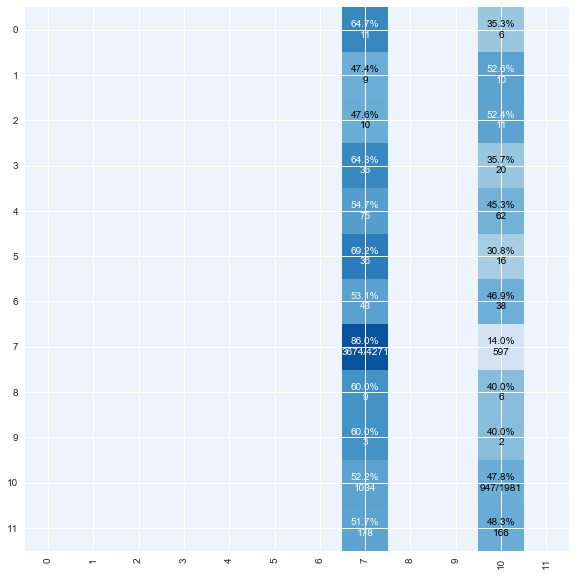

In [52]:
# Output confusion matrix
confusion_mat(dt_dev_labels_nodeplit500, pred_values_nodesplit500)

By boosting the signal from the non-NDF and non-US entries in our training data, we gained a 0.4% increase in accuracy.  Though we are still only predicting two values, we are doing so with greater accuracy.  Accurate predictions for NDF increased by 0.1%.  Accurate predictions for 'US' increased by 0.9%.

DIVYA JUST TRYING SOMETHING

In [58]:
train.head()

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,number_devices,longest_session,total_time_on_site,action_detail,first_hour,month_created,season_created,year_created,bin_age,bin_lang
7000,b4amt3o7t1,2014-01-22,20140122013130,MALE,32.0,basic,0,en,direct,direct,...,1.0,132051.0,488130.0,change_contact_host_dates,1,01,Winter,2014,30-45,en
7001,zyz889qlnv,2014-01-22,20140122013639,MALE,28.0,facebook,0,en,sem-brand,google,...,1.0,88649.0,304046.0,view_search_results,1,01,Winter,2014,Under30,en
7002,y975i3z4uz,2014-01-22,20140122014148,FEMALE,30.0,basic,0,en,sem-brand,google,...,1.0,364432.0,710668.0,confirm_email_link,1,01,Winter,2014,30-45,en
7003,143wftj6nx,2014-01-22,20140122014507,-unknown-,NaN,basic,0,en,direct,direct,...,1.0,277635.0,1271871.0,view_search_results,1,01,Winter,2014,Unknown,en
7004,0ar0xi9ujt,2014-01-22,20140122014618,FEMALE,27.0,basic,0,en,direct,direct,...,1.0,184047.0,772708.0,view_search_results,1,01,Winter,2014,Under30,en


In [59]:
dt_train.head()

,age,month_created,gender,signup_method,signup_flow,first_device_type,first_browser,affiliate_channel,number_visits,longest_session,total_time_on_site
0,15,2,2,1,0,6,12,6,4,2447,2595
1,23,4,2,1,0,3,26,6,48,48233,43758
2,17,1,1,1,0,3,6,5,83,56192,58233
3,12,3,0,0,0,6,6,5,126,45917,56004
4,17,3,2,0,0,3,26,5,567,59655,62704


In [ ]:
first_feature = ['bin_lang']
features = first_feature + cat_feat[1:] + num_feat
print features
print "\n"

def features_per_country():
### STUDENT START ###
    # Create training feature set with unigram features.
    #cv_train_uni = CountVectorizer();
    #train_features_uni = cv_train_uni.fit_transform(train_data)
    
    lr_one = LogisticRegression(penalty='l1', C=50)
    lr_one.fit(t, t_lab)
    print 'L1 top features weight table:'
    GetFeatureTable(features, lr_one.coef_)
    
    lr_two = LogisticRegression(penalty='l2', C=50)
    lr_two.fit(t, t_lab)
    print 'L2 top features weight table:'
    GetFeatureTable(features, lr_two.coef_)
    
    
def GetFeatureTable(feature_names, coef):
    top_20_features_indicies = []
    for label, features in enumerate(coef):
        sorted_features = np.sort(features)
        top_5 = sorted_features[len(sorted_features) - 5:]
        for value in top_5:
            top_20_features_indicies.append(features.tolist().index(value))
    
    print "Feature: \t{0}".format(unique_pred)
    for i, feature_index in enumerate(top_20_features_indicies):
        feature_name = feature_names[feature_index]
        feature_weights = [round(coef[label, feature_index], 4) for label in range(coef.shape[0])]
        print "{0}:\t\t{1}".format(feature_name, feature_weights)


### Error Analysis: Classification Results

In [ ]:
print "\nClassification results for node split: 500 on Dev Set Data \n"
print metrics.classification_report(dt_dev_labels_nodeplit500, pred_values_nodesplit500)